## ROMIU ROM ALGORITHM VALIDATION AGAINST OMCS

bLAH BLAH

In [143]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [144]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 
import math
from scipy import interpolate
from scipy.signal import savgol_filter
import csv
import pingouin as pg

In [145]:
def quaternion_multiply(quaternion1, quaternion0):
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

In [148]:
rom_gyro=[]
rom_comp=[]
rom_madg=[]
rom_mcp=[]
max_err_gyro=[]
max_err_comp=[]
_mean_x=[]
_mean_y=[]
_mean_z=[]
_gyro=[]
_comp=[]
_madg=[]
_mocap=[]
max_err_madg=[]
def validation(imu_file,mcp_file):
    imu_col =['gyrox1','gyroy1','gyroz1','accelx1','accely1','accelz1','Time']
    mcp_col=['Time','org_x','org_y','org_z','xvec_x','xvec_y','xvec_z','zvec_x','zvec_y','zvec_z']
    imu = pd.read_csv(imu_file, usecols=imu_col)
    mcp = pd.read_csv(mcp_file, usecols=mcp_col)
########################## extrapolation ######################################################
    t=imu.Time
    for i in range(9):
        mcp[mcp.columns[i+1]]=savgol_filter(mcp[mcp.columns[i+1]],51,3)
    for i in range(3):
        imu[imu.columns[i+3]]=savgol_filter(imu[imu.columns[i+3]],101,3)
    anew=pd.DataFrame()
    anew['Time']=t
    for col in mcp.columns:
        f=interpolate.interp1d(mcp.Time,mcp[col],fill_value="extrapolate")
        anew[col]=f(t)
    mcp=anew
########################### MOCAP ################################################################
    yvec1=[]
    xvec1=[]
    ort=[]
    for j in range(len(mcp.org_x)):
        xvec1=np.array([mcp.org_x[j]-mcp.xvec_x[j],mcp.org_y[j]-mcp.xvec_y[j],mcp.org_z[j]-mcp.xvec_z[j]])
        yvec1=np.array([mcp.org_x[j]-mcp.zvec_x[j],mcp.org_y[j]-mcp.zvec_y[j],mcp.org_z[j]-mcp.zvec_z[j]])
        normx=np.linalg.norm(xvec1)
        yvec2=yvec1-((np.dot(xvec1/normx,yvec1)/np.dot(xvec1/normx,xvec1/normx))*(xvec1/normx))
        normy=np.linalg.norm(yvec2)
        zvec1=np.cross(xvec1/normx,yvec2/normy)
        normz=np.linalg.norm(zvec1)
        ort1=np.array([[xvec1[0]/normx,yvec2[0]/normy,zvec1[0]/normz],
                    [xvec1[1]/normx,yvec2[1]/normy,zvec1[1]/normz],
                    [xvec1[2]/normx,yvec2[2]/normy,zvec1[2]/normz]])
        ort.append(ort1)
    MOCAP_an=[]
    for j in range(len(ort)):
        s1=np.dot(ort[0].transpose(),ort[j])
        th=(np.trace(s1)-1.0)*0.5
        if th>1:
            th=1
        t=np.arccos(th)
        MOCAP_an.append(t)
    MOCAP=np.rad2deg(MOCAP_an)
    _mocap.append(MOCAP)
############################# IMU ###################################################################  
    acc01=imu.accelx1
    acc02=imu.accely1
    acc03=imu.accelz1
    acc11=acc01-0.032051
    acc12=acc02+0.009519
    acc13=acc03+0.125074
    acc21=np.add((2.007463*acc11),(-0.000148*acc12))
    accx1=np.add(acc21,(0.002320*acc13))
    acc22=np.add((-0.000148*acc11),(1.993274*acc12))
    accy1=np.add(acc22,(-0.000060*acc13))
    acc23=np.add((0.002320*acc11),(-0.000060*acc12))
    accz1=np.add(acc23,( 1.986062*acc13))
  
    meen_x=np.var(imu.gyrox1[:1000])
    meen_y=np.var(imu.gyroy1[:1000])
    meen_z=np.var(imu.gyroz1[:1000])
    _mean_x.append(meen_x)
    _mean_y.append(meen_y)
    _mean_z.append(meen_z)
    if meen_x<5.5 and meen_y<5.5 and meen_z<5.5:
        angx=np.deg2rad(imu.gyrox1-np.mean(imu.gyrox1[:1000]))
        angy=np.deg2rad(imu.gyroy1-np.mean(imu.gyroy1[:1000]))
        angz=np.deg2rad(imu.gyroz1-np.mean(imu.gyroz1[:1000]))
    else:
        angx=np.deg2rad(imu.gyrox1-0.32372708)
        angy=np.deg2rad(imu.gyroy1-1.273188007)
        angz=np.deg2rad(imu.gyroz1+1.421987881) 
    meen=abs(np.mean(imu.gyrox1[:1000]))+abs(np.mean(imu.gyroy1[:1000]))+abs(np.mean(imu.gyroz1[:1000]))  
############################## Gyroscope ##################################################
    ang_gyro=[0]
    s_gyro=[1,0,0,0]
    for j in range(len(angx)-1):
            mag_gyro=np.linalg.norm([angx[j+1],angy[j+1],angz[j+1]]) 
            axis_of_rot=[angx[j+1]/mag_gyro,angy[j+1]/mag_gyro,angz[j+1]/mag_gyro]
            theta= 0.0017*mag_gyro
            q0=math.cos(theta/2)
            q1=(axis_of_rot[0])*math.sin(theta/2)
            q2=(axis_of_rot[1])*math.sin(theta/2)
            q3=(axis_of_rot[2])*math.sin(theta/2)
            q_gyro=[q0,q1,q2,q3]
            s_gyro=quaternion_multiply(s_gyro,q_gyro)
            norm_s_gyro= np.sqrt(s_gyro[0]*s_gyro[0]+s_gyro[1]*s_gyro[1]+s_gyro[2]*s_gyro[2]+s_gyro[3]*s_gyro[3])
            s_gyro=[s_gyro[0]/norm_s_gyro,s_gyro[1]/norm_s_gyro,s_gyro[2]/norm_s_gyro,s_gyro[3]/norm_s_gyro]
            ang_gyro.append(np.rad2deg(2*np.arccos(s_gyro[0])))
    IMU2=ang_gyro
    _gyro.append(IMU2)
    max_err_gyro.append(np.max(abs(np.subtract(IMU2[:len(IMU2)-500],MOCAP[:len(IMU2)-500]))))
###################### Complementary filter ###############################################
    if meen<=4.55:
        a=0.0001
    elif meen>4.55 and meen<=5.5:
        a=0.005
    else:
        a=0.007
    q4=[]
    Q1=[]
    ang_comp=[0]
    for j in range(len(angx)):
        Q=[0,accx1[j],accy1[j],accz1[j]]
        Q1.append(Q)
    for j in range(len(angx)-1):
        norm=np.linalg.norm([angx[j+1],angy[j+1],angz[j+1]]) 
        axis_of_rot=[angx[j+1]/norm,angy[j+1]/norm,angz[j+1]/norm]
        theta= 0.0017*norm
        q0=math.cos(theta/2)
        q1=(axis_of_rot[0])*math.sin(theta/2)
        q2=(axis_of_rot[1])*math.sin(theta/2)
        q3=(axis_of_rot[2])*math.sin(theta/2)
        q_comp=[q0,q1,q2,q3]
        q4.append(q_comp)
    s_comp=q4[0]
    for j in range(len(angx)-1):
        dummy=s_comp
        normq5=((dummy[0]*dummy[0])+(dummy[1]*dummy[1])+(dummy[2]*dummy[2])+(dummy[3]*dummy[3]))
        invq5=[s_comp[0]/normq5,-1*s_comp[1]/normq5,-1*s_comp[2]/normq5,-1*s_comp[3]/normq5]
        qupdat1=quaternion_multiply(s_comp,Q1[j+1])
        qupdate=quaternion_multiply(qupdat1,invq5)
        norm1=np.sqrt((qupdate[0]*qupdate[0])+(qupdate[1]*qupdate[1])+(qupdate[2]*qupdate[2])+(qupdate[3]*qupdate[3]))
        init=Q1[0][1:]
        new_qup=[qupdate[0]/norm1,qupdate[1]/norm1,qupdate[2]/norm1,qupdate[3]/norm1]
        rot_ax=np.cross(new_qup[1:],init)
        norm=np.linalg.norm(rot_ax)
        axis_of_rot=rot_ax/norm
        thet=(np.dot(new_qup[1:],init))/((np.linalg.norm(new_qup[1:])*np.linalg.norm(init)))
        theta=np.arccos(thet)
        q0=math.cos(a*theta/2)
        q1=(axis_of_rot[0])*math.sin(a*theta/2)
        q2=(axis_of_rot[1])*math.sin(a*theta/2)
        q3=(axis_of_rot[2])*math.sin(a*theta/2)
        qt=[q0,q1,q2,q3]
        s_comp=quaternion_multiply(qt,s_comp)
        norm_s_comp= np.sqrt(s_comp[0]*s_comp[0]+s_comp[1]*s_comp[1]+s_comp[2]*s_comp[2]+s_comp[3]*s_comp[3])
        s_comp=[s_comp[0]/norm_s_comp,s_comp[1]/norm_s_comp,s_comp[2]/norm_s_comp,s_comp[3]/norm_s_comp]
        finaltheta=np.rad2deg(2*np.arccos(s_comp[0]))
        if j<(len(q4)-1):
            s_comp=quaternion_multiply(s_comp,q4[j+1])
        ang_comp.append(finaltheta)
    IMU3=ang_comp
    _comp.append(IMU3)
    max_err_comp.append(np.max(abs(np.subtract(IMU3[:len(IMU3)-500],MOCAP[:len(IMU3)-500]))))
  ######################## Madgwick filter #############################################
    if  meen>4.55:
        beta=0.0001
    else:
        beta=0.000005
    s=[1,0,0,0]
    q=[1,0,0,0]
    ang_madg=[0]
    for j in range(len(angx)-1):
        q_madg=[0,angx[j+1],angy[j+1],angz[j+1]]
        # Normalise accelerometer measurement
        norm_acc=np.linalg.norm([accx1[j+1],accy1[j+1],accz1[j+1]])
        # Gradient descent algorithm corrective step
        f = np.array([
            2*((accx1[0]*(0.5-(q[2]*q[2])-(q[3]*q[3])))+(accy1[0]*((q[0]*q[3])+(q[1]*q[2])))+(accz1[0]*((q[1]*q[3])-(q[0]*q[2])))) - (accx1[j+1]/norm_acc),
            2*((accx1[0]*((q[1]*q[2])-(q[0]*q[3])))+(accy1[0]*((0.5-q[1]*q[1])-(q[3]*q[3])))+(accz1[0]*((q[0]*q[1])+(q[2]*q[3])))) - (accy1[j+1]/norm_acc),
            2*((accx1[0]*((q[0]*q[2])-(q[1]*q[3])))+(accy1[0]*((q[2]*q[3])-(q[0]*q[1])))+(accz1[0]*((0.5-q[1]*q[1])-(q[2]*q[2])))) - (accz1[j+1]/norm_acc)
        ])
        Jac = np.array([
            [(2*accy1[0]*q[3])-(2*accz1[0]*q[2]),(2*accy1[0]*q[2])+(2*accz1[0]*q[3]), ((-4*accx1[0]*q[2])+(2*accy1[0]*q[1])-(2*accz1[0]*q[0])),((-4*accx1[0]*q[3])+(2*accy1[0]*q[0])+(2*accz1[0]*q[1]))],
            [(-2*accx1[0]*q[3])+(2*accz1[0]*q[1]),((2*accx1[0]*q[2])-(4*accy1[0]*q[1])+(2*accz1[0]*q[0])),(2*accx1[0]*q[1])+(2*accz1[0]*q[3]), ((-2*accx1[0]*q[0])+(-4*accy1[0]*q[3])+(2*accz1[0]*q[2]))],
            [(2*accx1[0]*q[2])-(2*accy1[0]*q[1]), ((2*accx1[0]*q[3])-(2*accy1[0]*q[0])-(4*accz1[0]*q[1])), ( (2*accx1[0]*q[0])+(2*accy1[0]*q[3])+(-4*accz1[0]*q[2])),(2*accx1[0]*q[1])+(2*accy1[0]*q[2]) ]
        ])
        step =Jac.T.dot(f)
        norm_step=np.sqrt((step[0]*step[0])+(step[1]*step[1])+(step[2]*step[2])+(step[3]*step[3]))
        if norm_step!=0:
            step=[(step[0])/norm_step,(step[1])/norm_step,(step[2])/norm_step,(step[3])/norm_step]
        s1=[s[0]*0.5,s[1]*0.5,s[2]*0.5,s[3]*0.5]
        der_w=quaternion_multiply(s1,q_madg)
        der_w=[der_w[0]*0.0017,der_w[1]*0.0017,der_w[2]*0.0017,der_w[3]*0.0017]
        step=[step[0]*beta*0.0017,step[1]*beta*0.0017,step[2]*beta*0.0017,step[3]*beta*0.0017]
        s=np.add(s,der_w)
        q=np.subtract(s,step)
        s=q
        l=q
        if q[0]>1:
            l[0]=1
        theta=np.rad2deg(2*np.arccos(l[0]))
        ang_madg.append(theta)
    IMU4=ang_madg
    _madg.append(IMU4)
    max_err_madg.append(np.max(abs(np.subtract(IMU4[:len(IMU4)-500],MOCAP[:len(IMU4)-500]))))
    ang12=np.max(IMU2)
    ang13=np.max(IMU3)
    ang14=np.max(IMU4)
    ang2=np.max(MOCAP)
    rom_gyro.append(ang12)
    rom_comp.append(ang13)
    rom_madg.append(ang14)
    rom_mcp.append(ang2)
    out=[IMU2,IMU3,IMU4,MOCAP,imu,mcp]
    return out

In [149]:
_111=validation(r'C:\Phase1\IMU_data\36307\36307_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\36307\36307_1\e36307_1_AA_1.csv')
_112=validation(r'C:\Phase1\IMU_data\36307\36307_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\36307\36307_1\e36307_1_AA_2.csv')
_113=validation(r'C:\Phase1\IMU_data\36307\36307_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\36307\36307_1\e36307_1_AA_3.csv')
_121=validation(r'C:\Phase1\IMU_data\36307\36307_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\36307\36307_2\e36307_2_AA_1.csv')
_122=validation(r'C:\Phase1\IMU_data\36307\36307_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\36307\36307_2\e36307_2_AA_2.csv')
_123=validation(r'C:\Phase1\IMU_data\36307\36307_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\36307\36307_2\e36307_2_AA_3.csv')
_131=validation(r'C:\Phase1\IMU_data\36307\36307_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\36307\36307_3\e36307_3_AA_1.csv')
_132=validation(r'C:\Phase1\IMU_data\36307\36307_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\36307\36307_3\e36307_3_AA_2.csv')
_133=validation(r'C:\Phase1\IMU_data\36307\36307_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\36307\36307_3\e36307_3_AA_3.csv')

In [150]:
_211=validation(r'C:\Phase1\IMU_data\36510\36510_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\36510\36510_1\e36510_1_AA_1.csv')
_212=validation(r'C:\Phase1\IMU_data\36510\36510_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\36510\36510_1\e36510_1_AA_2.csv')
_213=validation(r'C:\Phase1\IMU_data\36510\36510_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\36510\36510_1\e36510_1_AA_3.csv')
_221=validation(r'C:\Phase1\IMU_data\36510\36510_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\36510\36510_2\e36510_2_AA_1.csv')
_222=validation(r'C:\Phase1\IMU_data\36510\36510_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\36510\36510_2\e36510_2_AA_2.csv')
_223=validation(r'C:\Phase1\IMU_data\36510\36510_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\36510\36510_2\e36510_2_AA_3.csv')
_231=validation(r'C:\Phase1\IMU_data\36510\36510_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\36510\36510_3\e36510_3_AA_1.csv')
_232=validation(r'C:\Phase1\IMU_data\36510\36510_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\36510\36510_3\e36510_3_AA_2.csv')
_233=validation(r'C:\Phase1\IMU_data\36510\36510_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\36510\36510_3\e36510_3_AA_3.csv')

In [151]:
_311=validation(r'C:\Phase1\IMU_data\053746h\053746h_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\053746h\053746h_1\e053746h_1_AA_1.csv')
_312=validation(r'C:\Phase1\IMU_data\053746h\053746h_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\053746h\053746h_1\e053746h_1_AA_2.csv')
_313=validation(r'C:\Phase1\IMU_data\053746h\053746h_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\053746h\053746h_1\e053746h_1_AA_3.csv')
_321=validation(r'C:\Phase1\IMU_data\053746h\053746h_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\053746h\053746h_2\e053746h_2_AA_1.csv')
_322=validation(r'C:\Phase1\IMU_data\053746h\053746h_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\053746h\053746h_2\e053746h_2_AA_2.csv')
_323=validation(r'C:\Phase1\IMU_data\053746h\053746h_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\053746h\053746h_2\e053746h_2_AA_3.csv')
_331=validation(r'C:\Phase1\IMU_data\053746h\053746h_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\053746h\053746h_3\e053746h_3_AA_1.csv')
_332=validation(r'C:\Phase1\IMU_data\053746h\053746h_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\053746h\053746h_3\e053746h_3_AA_2.csv')
_333=validation(r'C:\Phase1\IMU_data\053746h\053746h_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\053746h\053746h_3\e053746h_3_AA_3.csv')

In [152]:
_411=validation(r'C:\Phase1\IMU_data\063484d\063484d_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\063484d\063484d_1\e063484d_1_AA_1.csv')
_412=validation(r'C:\Phase1\IMU_data\063484d\063484d_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\063484d\063484d_1\e063484d_1_AA_2.csv')
_413=validation(r'C:\Phase1\IMU_data\063484d\063484d_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\063484d\063484d_1\e063484d_1_AA_3.csv')
_421=validation(r'C:\Phase1\IMU_data\063484d\063484d_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\063484d\063484d_2\e063484d_2_AA_1.csv')
_422=validation(r'C:\Phase1\IMU_data\063484d\063484d_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\063484d\063484d_2\e063484d_2_AA_2.csv')
_423=validation(r'C:\Phase1\IMU_data\063484d\063484d_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\063484d\063484d_2\e063484d_2_AA_3.csv')
_431=validation(r'C:\Phase1\IMU_data\063484d\063484d_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\063484d\063484d_3\e063484d_3_AA_1.csv')
_432=validation(r'C:\Phase1\IMU_data\063484d\063484d_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\063484d\063484d_3\e063484d_3_AA_2.csv')
_433=validation(r'C:\Phase1\IMU_data\063484d\063484d_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\063484d\063484d_3\e063484d_3_AA_3.csv')

In [153]:
_511=validation(r'C:\Phase1\IMU_data\153913c\153913c_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\153913c\153913c_1\e153913c_1_AA_1.csv')
_512=validation(r'C:\Phase1\IMU_data\153913c\153913c_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\153913c\153913c_1\e153913c_1_AA_2.csv')
_513=validation(r'C:\Phase1\IMU_data\153913c\153913c_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\153913c\153913c_1\e153913c_1_AA_3.csv')
_521=validation(r'C:\Phase1\IMU_data\153913c\153913c_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\153913c\153913c_2\e153913c_2_AA_1.csv')
_522=validation(r'C:\Phase1\IMU_data\153913c\153913c_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\153913c\153913c_2\e153913c_2_AA_2.csv')
_523=validation(r'C:\Phase1\IMU_data\153913c\153913c_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\153913c\153913c_2\e153913c_2_AA_3.csv')
_531=validation(r'C:\Phase1\IMU_data\153913c\153913c_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\153913c\153913c_3\e153913c_3_AA_1.csv')
_532=validation(r'C:\Phase1\IMU_data\153913c\153913c_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\153913c\153913c_3\e153913c_3_AA_2.csv')
_533=validation(r'C:\Phase1\IMU_data\153913c\153913c_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\153913c\153913c_3\e153913c_3_AA_3.csv')

In [154]:
_611=validation(r'C:\Phase1\IMU_data\334584H\334584H_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\334584H\334584H_1\e334584H_1_AA_1.csv')
_612=validation(r'C:\Phase1\IMU_data\334584H\334584H_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\334584H\334584H_1\e334584H_1_AA_2.csv')
_613=validation(r'C:\Phase1\IMU_data\334584H\334584H_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\334584H\334584H_1\e334584H_1_AA_3.csv')
_621=validation(r'C:\Phase1\IMU_data\334584H\334584H_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\334584H\334584H_2\e334584H_2_AA_1.csv')
_622=validation(r'C:\Phase1\IMU_data\334584H\334584H_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\334584H\334584H_2\e334584H_2_AA_2.csv')
_623=validation(r'C:\Phase1\IMU_data\334584H\334584H_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\334584H\334584H_2\e334584H_2_AA_3.csv')
_631=validation(r'C:\Phase1\IMU_data\334584H\334584H_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\334584H\334584H_3\e334584H_3_AA_1.csv')
_632=validation(r'C:\Phase1\IMU_data\334584H\334584H_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\334584H\334584H_3\e334584H_3_AA_2.csv')
_633=validation(r'C:\Phase1\IMU_data\334584H\334584H_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\334584H\334584H_3\e334584H_3_AA_3.csv')

In [155]:
_711=validation(r'C:\Phase1\IMU_data\583885p\583885p_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\583885p\583885p_1\e583885P_1_AA_1.csv')
_712=validation(r'C:\Phase1\IMU_data\583885p\583885p_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\583885p\583885p_1\e583885P_1_AA_2.csv')
_713=validation(r'C:\Phase1\IMU_data\583885p\583885p_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\583885p\583885p_1\e583885P_1_AA_3.csv')
_721=validation(r'C:\Phase1\IMU_data\583885p\583885p_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\583885p\583885p_2\e583885p_2_AA_1.csv')
_722=validation(r'C:\Phase1\IMU_data\583885p\583885p_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\583885p\583885p_2\e583885p_2_AA_2.csv')
_723=validation(r'C:\Phase1\IMU_data\583885p\583885p_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\583885p\583885p_2\e583885p_2_AA_3.csv')
_731=validation(r'C:\Phase1\IMU_data\583885p\583885p_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\583885p\583885p_3\e583885p_3_AA_1.csv')
_732=validation(r'C:\Phase1\IMU_data\583885p\583885p_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\583885p\583885p_3\e583885p_3_AA_2.csv')
_733=validation(r'C:\Phase1\IMU_data\583885p\583885p_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\583885p\583885p_3\e583885p_3_AA_3.csv')

In [156]:
_811=validation(r'C:\Phase1\IMU_data\587348H\587348H_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\587348H\587348H_1\e587348H_1_AA_1.csv')
_812=validation(r'C:\Phase1\IMU_data\587348H\587348H_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\587348H\587348H_1\e587348H_1_AA_2.csv')
_813=validation(r'C:\Phase1\IMU_data\587348H\587348H_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\587348H\587348H_1\e587348H_1_AA_2.csv')#repeated
_821=validation(r'C:\Phase1\IMU_data\587348H\587348H_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\587348H\587348H_2\e587348H_2_AA_1.csv')
_822=validation(r'C:\Phase1\IMU_data\587348H\587348H_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\587348H\587348H_2\e587348H_2_AA_2.csv')
_823=validation(r'C:\Phase1\IMU_data\587348H\587348H_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\587348H\587348H_2\e587348H_2_AA_3.csv')
_831=validation(r'C:\Phase1\IMU_data\587348H\587348H_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\587348H\587348H_3\e587348H_3_AA_1.csv')
_832=validation(r'C:\Phase1\IMU_data\587348H\587348H_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\587348H\587348H_3\e587348H_3_AA_2.csv')
_833=validation(r'C:\Phase1\IMU_data\587348H\587348H_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\587348H\587348H_3\e587348H_3_AA_3.csv')

In [157]:
_911=validation(r'C:\Phase1\IMU_data\624765p\624765p_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624765p\624765p_1\e624765P_1_AA_1.csv')
_912=validation(r'C:\Phase1\IMU_data\624765p\624765p_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624765p\624765p_1\e624765P_1_AA_2.csv')
_913=validation(r'C:\Phase1\IMU_data\624765p\624765p_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624765p\624765p_1\e624765P_1_AA_3.csv')
_921=validation(r'C:\Phase1\IMU_data\624765p\624765p_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624765p\624765p_2\e624765P_2_AA_1.csv')
_922=validation(r'C:\Phase1\IMU_data\624765p\624765p_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624765p\624765p_2\e624765P_2_AA_2.csv')
_923=validation(r'C:\Phase1\IMU_data\624765p\624765p_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624765p\624765p_2\e624765P_2_AA_3.csv')
_931=validation(r'C:\Phase1\IMU_data\624765p\624765p_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624765p\624765p_3\e624765p_3_AA_1.csv')
_932=validation(r'C:\Phase1\IMU_data\624765p\624765p_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624765p\624765p_3\e624765p_3_AA_2.csv')
_933=validation(r'C:\Phase1\IMU_data\624765p\624765p_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624765p\624765p_3\e624765p_3_AA_3.csv')

In [158]:
_1011=validation(r'C:\Phase1\IMU_data\624769p\624769p_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624769p\624769p_1\e624769P_1_AA_t1.csv')
_1012=validation(r'C:\Phase1\IMU_data\624769p\624769p_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624769p\624769p_1\e624769P_1_AA_t2.csv')
_1013=validation(r'C:\Phase1\IMU_data\624769p\624769p_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624769p\624769p_1\e624769P_1_AA_t3.csv')
_1021=validation(r'C:\Phase1\IMU_data\624769p\624769p_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624769p\624769p_2\e624769P_2_AA_t1.csv')
_1022=validation(r'C:\Phase1\IMU_data\624769p\624769p_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624769p\624769p_2\e624769P_2_AA_t2.csv')
_1023=validation(r'C:\Phase1\IMU_data\624769p\624769p_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624769p\624769p_2\e624769P_2_AA_t3.csv')
_1031=validation(r'C:\Phase1\IMU_data\624769p\624769p_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624769p\624769p_3\e624769P_3_AA_t1.csv')
_1032=validation(r'C:\Phase1\IMU_data\624769p\624769p_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624769p\624769p_3\e624769P_3_AA_t2.csv')
_1033=validation(r'C:\Phase1\IMU_data\624769p\624769p_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624769p\624769p_3\e624769P_3_AA_t3.csv')

In [159]:
_1111=validation(r'C:\Phase1\IMU_data\624773p\624773p_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624773p\624773p_1\e624773P_1_AA_t1.csv')
_1112=validation(r'C:\Phase1\IMU_data\624773p\624773p_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624773p\624773p_1\e624773P_1_AA_t2.csv')
_1113=validation(r'C:\Phase1\IMU_data\624773p\624773p_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624773p\624773p_1\e624773P_1_AA_t3.csv')
_1121=validation(r'C:\Phase1\IMU_data\624773p\624773p_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624773p\624773p_2\e624773P_2_AA_t1.csv')
_1122=validation(r'C:\Phase1\IMU_data\624773p\624773p_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624773p\624773p_2\e624773P_2_AA_t2.csv')
_1123=validation(r'C:\Phase1\IMU_data\624773p\624773p_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624773p\624773p_2\e624773P_2_AA_t3.csv')
_1131=validation(r'C:\Phase1\IMU_data\624773p\624773p_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624773p\624773p_3\e624773P_3_AA_t1.csv')
_1132=validation(r'C:\Phase1\IMU_data\624773p\624773p_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624773p\624773p_3\e624773P_3_AA_t2.csv')
_1133=validation(r'C:\Phase1\IMU_data\624773p\624773p_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624773p\624773p_3\e624773P_3_AA_t3.csv')

In [160]:
_1211=validation(r'C:\Phase1\IMU_data\624806p\624806p_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624806p\624806p_1\e624806P_1_AA_t1.csv')
_1212=validation(r'C:\Phase1\IMU_data\624806p\624806p_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624806p\624806p_1\e624806P_1_AA_t2.csv')
_1213=validation(r'C:\Phase1\IMU_data\624806p\624806p_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624806p\624806p_1\e624806P_1_AA_t3.csv')
_1221=validation(r'C:\Phase1\IMU_data\624806p\624806p_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624806p\624806p_2\e624806P_2_AA_t1.csv')
_1222=validation(r'C:\Phase1\IMU_data\624806p\624806p_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624806p\624806p_2\e624806P_2_AA_t2.csv')
_1223=validation(r'C:\Phase1\IMU_data\624806p\624806p_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624806p\624806p_2\e624806P_2_AA_t3.csv')
_1231=validation(r'C:\Phase1\IMU_data\624806p\624806p_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624806p\624806p_3\e624806P_3_AA_t1.csv')
_1232=validation(r'C:\Phase1\IMU_data\624806p\624806p_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624806p\624806p_3\e624806P_3_AA_t2.csv')
_1233=validation(r'C:\Phase1\IMU_data\624806p\624806p_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624806p\624806p_3\e624806P_3_AA_t3.csv')

In [161]:
_1311=validation(r'C:\Phase1\IMU_data\718255p\718255p_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\718255p\718255p_1\e718255P_1_AA_1.csv')
_1312=validation(r'C:\Phase1\IMU_data\718255p\718255p_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\718255p\718255p_1\e718255P_1_AA_2.csv')
_1313=validation(r'C:\Phase1\IMU_data\718255p\718255p_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\718255p\718255p_1\e718255P_1_AA_3.csv')
_1321=validation(r'C:\Phase1\IMU_data\718255p\718255p_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\718255p\718255p_2\e718255P_2_AA_1.csv')
_1322=validation(r'C:\Phase1\IMU_data\718255p\718255p_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\718255p\718255p_2\e718255P_2_AA_2.csv')
_1323=validation(r'C:\Phase1\IMU_data\718255p\718255p_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\718255p\718255p_2\e718255P_2_AA_3.csv')
_1331=validation(r'C:\Phase1\IMU_data\718255p\718255p_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\718255p\718255p_3\e718255p_3_AA_2.csv')#repeated one
_1332=validation(r'C:\Phase1\IMU_data\718255p\718255p_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\718255p\718255p_3\e718255p_3_AA_2.csv')
_1333=validation(r'C:\Phase1\IMU_data\718255p\718255p_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\718255p\718255p_3\e718255p_3_AA_3.csv')

In [162]:
# _1411=validation(r'C:\Phase1\IMU_data\723182H\723182H_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\723182H\723182H_1\e723182H_AA1_t1.csv')
# _1412=validation(r'C:\Phase1\IMU_data\723182H\723182H_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\723182H\723182H_1\e723182H_AA1_t2.csv')
# _1413=validation(r'C:\Phase1\IMU_data\723182H\723182H_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\723182H\723182H_1\e723182H_AA1_t3.csv')
# _1421=validation(r'C:\Phase1\IMU_data\723182H\723182H_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\723182H\723182H_2\e723182H_AA2_t3.csv')#
# _1422=validation(r'C:\Phase1\IMU_data\723182H\723182H_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\723182H\723182H_2\e723182H_AA2_t3.csv')#
# _1423=validation(r'C:\Phase1\IMU_data\723182H\723182H_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\723182H\723182H_2\e723182H_AA2_t3.csv')
# _1431=validation(r'C:\Phase1\IMU_data\723182H\723182H_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\723182H\723182H_3\e723182H_3_AA_t1.csv')
# _1432=validation(r'C:\Phase1\IMU_data\723182H\723182H_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\723182H\723182H_3\e723182H_3_AA_t2.csv')
# _1433=validation(r'C:\Phase1\IMU_data\723182H\723182H_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\723182H\723182H_3\e723182H_3_AA_t3.csv')

In [163]:
_1511=validation(r'C:\Phase1\IMU_data\723247H\723247H_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\723247H\723247H_1\e723247H_1_AA_t1.csv')
_1512=validation(r'C:\Phase1\IMU_data\723247H\723247H_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\723247H\723247H_1\e723247H_1_AA_t2.csv')
_1513=validation(r'C:\Phase1\IMU_data\723247H\723247H_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\723247H\723247H_1\e723247H_1_AA_t3.csv')
_1521=validation(r'C:\Phase1\IMU_data\723247H\723247H_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\723247H\723247H_2\e723247H_2_AA_t1.csv')
_1522=validation(r'C:\Phase1\IMU_data\723247H\723247H_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\723247H\723247H_2\e723247H_2_AA_t2.csv')
_1523=validation(r'C:\Phase1\IMU_data\723247H\723247H_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\723247H\723247H_2\e723247H_2_AA_t3.csv')
_1531=validation(r'C:\Phase1\IMU_data\723247H\723247H_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\723247H\723247H_3\e723247H_3_AA_t1.csv')
_1532=validation(r'C:\Phase1\IMU_data\723247H\723247H_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\723247H\723247H_3\e723247H_3_AA_t2.csv')
_1533=validation(r'C:\Phase1\IMU_data\723247H\723247H_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\723247H\723247H_3\e723247H_3_AA_t3.csv')

In [164]:
_1611=validation(r'C:\Phase1\IMU_data\730502H\730502H_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\730502H\730502H_1\e730502H_1_AA_t1.csv')
_1612=validation(r'C:\Phase1\IMU_data\730502H\730502H_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\730502H\730502H_1\e730502H_1_AA_t2.csv')
_1613=validation(r'C:\Phase1\IMU_data\730502H\730502H_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\730502H\730502H_1\e730502H_1_AA_t3.csv')
_1621=validation(r'C:\Phase1\IMU_data\730502H\730502H_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\730502H\730502H_1\e730502H_1_AA_t1.csv')
_1622=validation(r'C:\Phase1\IMU_data\730502H\730502H_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\730502H\730502H_1\e730502H_1_AA_t2.csv')
_1623=validation(r'C:\Phase1\IMU_data\730502H\730502H_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\730502H\730502H_1\e730502H_1_AA_t3.csv')
_1631=validation(r'C:\Phase1\IMU_data\730502H\730502H_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\730502H\730502H_3\e730502H_3_AA_t1.csv')
_1632=validation(r'C:\Phase1\IMU_data\730502H\730502H_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\730502H\730502H_3\e730502H_3_AA_t2.csv')
_1633=validation(r'C:\Phase1\IMU_data\730502H\730502H_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\730502H\730502H_3\e730502H_3_AA_t3.csv')

In [165]:
_1711=validation(r'C:\Phase1\IMU_data\850292d\850292d_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\850292d\850292d_1\e850292d_1_AA_1.csv')
_1712=validation(r'C:\Phase1\IMU_data\850292d\850292d_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\850292d\850292d_1\e850292d_1_AA_2.csv')
_1713=validation(r'C:\Phase1\IMU_data\850292d\850292d_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\850292d\850292d_1\e850292d_1_AA_3.csv')
_1721=validation(r'C:\Phase1\IMU_data\850292d\850292d_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\850292d\850292d_2\e850292d_2_AA_1.csv')
_1722=validation(r'C:\Phase1\IMU_data\850292d\850292d_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\850292d\850292d_2\e850292d_2_AA_2.csv')
_1723=validation(r'C:\Phase1\IMU_data\850292d\850292d_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\850292d\850292d_2\e850292d_2_AA_3.csv')
_1731=validation(r'C:\Phase1\IMU_data\850292d\850292d_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\850292d\850292d_3\e850292d_3_AA_2.csv')#repeated one
_1732=validation(r'C:\Phase1\IMU_data\850292d\850292d_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\850292d\850292d_3\e850292d_3_AA_2.csv')
_1733=validation(r'C:\Phase1\IMU_data\850292d\850292d_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\850292d\850292d_3\e850292d_3_AA_3.csv')

In [166]:
_1811=validation(r'C:\Phase1\IMU_data\889497c\889497c_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\889497c\889497c_1\e889497C_1_AA_t1.csv')
_1812=validation(r'C:\Phase1\IMU_data\889497c\889497c_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\889497c\889497c_1\e889497C_1_AA_t2.csv')
_1813=validation(r'C:\Phase1\IMU_data\889497c\889497c_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\889497c\889497c_1\e889497C_1_AA_t3.csv')
_1821=validation(r'C:\Phase1\IMU_data\889497c\889497c_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\889497c\889497c_2\e889497C_2_AA_t1.csv')
_1822=validation(r'C:\Phase1\IMU_data\889497c\889497c_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\889497c\889497c_2\e889497C_2_AA_t2.csv')
_1823=validation(r'C:\Phase1\IMU_data\889497c\889497c_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\889497c\889497c_2\e889497C_2_AA_t3.csv')
_1831=validation(r'C:\Phase1\IMU_data\889497c\889497c_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\889497c\889497c_3\e889497c_3_AA_t1.csv')
_1832=validation(r'C:\Phase1\IMU_data\889497c\889497c_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\889497c\889497c_3\e889497c_3_AA_t2.csv')
_1833=validation(r'C:\Phase1\IMU_data\889497c\889497c_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\889497c\889497c_3\e889497c_3_AA_t3.csv')

In [167]:
_1911=validation(r'C:\Phase1\IMU_data\964005g\964005g_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\964005g\964005g_1\e964005g_1_AA_1.csv')
_1912=validation(r'C:\Phase1\IMU_data\964005g\964005g_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\964005g\964005g_1\e964005g_1_AA_2.csv')
_1913=validation(r'C:\Phase1\IMU_data\964005g\964005g_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\964005g\964005g_1\e964005g_1_AA_3.csv')
_1921=validation(r'C:\Phase1\IMU_data\964005g\964005g_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\964005g\964005g_2\e964005g_2_AA_1.csv')
_1922=validation(r'C:\Phase1\IMU_data\964005g\964005g_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\964005g\964005g_2\e964005g_2_AA_2.csv')
_1923=validation(r'C:\Phase1\IMU_data\964005g\964005g_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\964005g\964005g_2\e964005g_2_AA_3.csv')
_1931=validation(r'C:\Phase1\IMU_data\964005g\964005g_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\964005g\964005g_3\e964005g_3_AA_1.csv')
_1932=validation(r'C:\Phase1\IMU_data\964005g\964005g_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\964005g\964005g_3\e964005g_3_AA_2.csv')
_1933=validation(r'C:\Phase1\IMU_data\964005g\964005g_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\964005g\964005g_3\e964005g_3_AA_3.csv')

In [168]:
_2011=validation(r'C:\Phase1\IMU_data\adarsh\adarsh_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\adarsh\adarsh_1\eadarsh_1_AA_1.csv')
_2012=validation(r'C:\Phase1\IMU_data\adarsh\adarsh_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\adarsh\adarsh_1\eadarsh_1_AA_2.csv')
_2013=validation(r'C:\Phase1\IMU_data\adarsh\adarsh_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\adarsh\adarsh_1\eadarsh_1_AA_3.csv')
_2021=validation(r'C:\Phase1\IMU_data\adarsh\adarsh_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\adarsh\adarsh_1\eadarsh_1_AA_1.csv')
_2022=validation(r'C:\Phase1\IMU_data\adarsh\adarsh_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\adarsh\adarsh_1\eadarsh_1_AA_2.csv')
_2023=validation(r'C:\Phase1\IMU_data\adarsh\adarsh_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\adarsh\adarsh_1\eadarsh_1_AA_3.csv')
_2031=validation(r'C:\Phase1\IMU_data\adarsh\adarsh_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\adarsh\adarsh_3\eadarsh_3_AA_1.csv')
_2032=validation(r'C:\Phase1\IMU_data\adarsh\adarsh_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\adarsh\adarsh_3\eadarsh_3_AA_2.csv')
_2033=validation(r'C:\Phase1\IMU_data\adarsh\adarsh_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\adarsh\adarsh_3\eadarsh_3_AA_3.csv')

In [169]:
_2111=validation(r'C:\Phase1\IMU_data\anand\anand_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\anand\anand_1\eanand_1_AA_t1.csv')
_2112=validation(r'C:\Phase1\IMU_data\anand\anand_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\anand\anand_1\eanand_1_AA_t2.csv')
_2113=validation(r'C:\Phase1\IMU_data\anand\anand_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\anand\anand_1\eanand_1_AA_t3.csv')
_2121=validation(r'C:\Phase1\IMU_data\anand\anand_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\anand\anand_2\eanand_2_AA_t1.csv')
_2122=validation(r'C:\Phase1\IMU_data\anand\anand_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\anand\anand_2\eanand_2_AA_t2.csv')
_2123=validation(r'C:\Phase1\IMU_data\anand\anand_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\anand\anand_2\eanand_2_AA_t3.csv')
_2131=validation(r'C:\Phase1\IMU_data\anand\anand_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\anand\anand_3\eanand_3_AA_t1.csv')
_2132=validation(r'C:\Phase1\IMU_data\anand\anand_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\anand\anand_3\eanand_3_AA_t2.csv')
_2133=validation(r'C:\Phase1\IMU_data\anand\anand_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\anand\anand_3\eanand_3_AA_t3.csv')

In [170]:
_2211=validation(r'C:\Phase1\IMU_data\arjun\arjun_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\arjun\arjun_1\earjun_1_AA_t1.csv')
_2212=validation(r'C:\Phase1\IMU_data\arjun\arjun_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\arjun\arjun_1\earjun_1_AA_t2.csv')
_2213=validation(r'C:\Phase1\IMU_data\arjun\arjun_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\arjun\arjun_1\earjun_1_AA_t3.csv')
_2221=validation(r'C:\Phase1\IMU_data\arjun\arjun_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\arjun\arjun_2\earjun_2_AA_t1.csv')
_2222=validation(r'C:\Phase1\IMU_data\arjun\arjun_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\arjun\arjun_2\earjun_2_AA_t2.csv')
_2223=validation(r'C:\Phase1\IMU_data\arjun\arjun_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\arjun\arjun_2\earjun_2_AA_t3.csv')
_2231=validation(r'C:\Phase1\IMU_data\arjun\arjun_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\arjun\arjun_3\earjun_3_AA_t1.csv')
_2232=validation(r'C:\Phase1\IMU_data\arjun\arjun_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\arjun\arjun_3\earjun_3_AA_t2.csv')
_2233=validation(r'C:\Phase1\IMU_data\arjun\arjun_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\arjun\arjun_3\earjun_3_AA_t3.csv')

In [171]:
_2311=validation(r'C:\Phase1\IMU_data\dyan\dyan_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\dyan\dyan_1\edyan_1_AA_t1.csv')
_2312=validation(r'C:\Phase1\IMU_data\dyan\dyan_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\dyan\dyan_1\edyan_1_AA_t2.csv')
_2313=validation(r'C:\Phase1\IMU_data\dyan\dyan_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\dyan\dyan_1\edyan_1_AA_t3.csv')
_2321=validation(r'C:\Phase1\IMU_data\dyan\dyan_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\dyan\dyan_2\edyan_2_AA_t2.csv')#repeated one
_2322=validation(r'C:\Phase1\IMU_data\dyan\dyan_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\dyan\dyan_2\edyan_2_AA_t2.csv')
_2323=validation(r'C:\Phase1\IMU_data\dyan\dyan_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\dyan\dyan_2\edyan_2_AA_t3.csv')
_2331=validation(r'C:\Phase1\IMU_data\dyan\dyan_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\dyan\dyan_3\edyan_3_AA_t1.csv')
_2332=validation(r'C:\Phase1\IMU_data\dyan\dyan_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\dyan\dyan_3\edyan_3_AA_t2.csv')
_2333=validation(r'C:\Phase1\IMU_data\dyan\dyan_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\dyan\dyan_3\edyan_3_AA_t3.csv')

In [172]:
_2411=validation(r'C:\Phase1\IMU_data\tyagu\tyagu_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\tyagu\tyagu_1\etyagu_1_AA_t1.csv')
_2412=validation(r'C:\Phase1\IMU_data\tyagu\tyagu_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\tyagu\tyagu_1\etyagu_1_AA_t2.csv')
_2413=validation(r'C:\Phase1\IMU_data\tyagu\tyagu_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\tyagu\tyagu_1\etyagu_1_AA_t3.csv')
_2421=validation(r'C:\Phase1\IMU_data\tyagu\tyagu_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\tyagu\tyagu_2\etyagu_2_AA_t1.csv')
_2422=validation(r'C:\Phase1\IMU_data\tyagu\tyagu_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\tyagu\tyagu_2\etyagu_2_AA_t2.csv')
_2423=validation(r'C:\Phase1\IMU_data\tyagu\tyagu_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\tyagu\tyagu_2\etyagu_2_AA_t3.csv')
_2431=validation(r'C:\Phase1\IMU_data\tyagu\tyagu_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\tyagu\tyagu_3\etyagu_3_AA_t1.csv')
_2432=validation(r'C:\Phase1\IMU_data\tyagu\tyagu_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\tyagu\tyagu_3\etyagu_3_AA_t2.csv')
_2433=validation(r'C:\Phase1\IMU_data\tyagu\tyagu_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\tyagu\tyagu_3\etyagu_3_AA_t3.csv')

In [173]:
_2511=validation(r'C:\Phase1\IMU_data\kevin\kevin_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\kevin\kevin_1\ekevin_1_AA_1.csv')
_2512=validation(r'C:\Phase1\IMU_data\kevin\kevin_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\kevin\kevin_1\ekevin_1_AA_2.csv')
_2513=validation(r'C:\Phase1\IMU_data\kevin\kevin_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\kevin\kevin_1\ekevin_1_AA_3.csv')
_2521=validation(r'C:\Phase1\IMU_data\kevin\kevin_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\kevin\kevin_2\ekevin_2_AA_1.csv')
_2522=validation(r'C:\Phase1\IMU_data\kevin\kevin_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\kevin\kevin_2\ekevin_2_AA_2.csv')
_2523=validation(r'C:\Phase1\IMU_data\kevin\kevin_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\kevin\kevin_2\ekevin_2_AA_3.csv')
_2531=validation(r'C:\Phase1\IMU_data\kevin\kevin_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\kevin\kevin_3\ekevin_3_AA_1.csv')
_2532=validation(r'C:\Phase1\IMU_data\kevin\kevin_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\kevin\kevin_3\ekevin_3_AA_2.csv')
_2533=validation(r'C:\Phase1\IMU_data\kevin\kevin_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\kevin\kevin_3\ekevin_3_AA_3.csv')

In [174]:
_2611=validation(r'C:\Phase1\IMU_data\2072419\2072419_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\2072419\2072419_1\e2072419_1_AA_1.csv')
_2612=validation(r'C:\Phase1\IMU_data\2072419\2072419_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\2072419\2072419_1\e2072419_1_AA_2.csv')
_2613=validation(r'C:\Phase1\IMU_data\2072419\2072419_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\2072419\2072419_1\e2072419_1_AA_3.csv')
_2621=validation(r'C:\Phase1\IMU_data\2072419\2072419_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\2072419\2072419_2\e2072419_2_AA_1.csv')
_2622=validation(r'C:\Phase1\IMU_data\2072419\2072419_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\2072419\2072419_2\e2072419_2_AA_2.csv')
_2623=validation(r'C:\Phase1\IMU_data\2072419\2072419_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\2072419\2072419_2\e2072419_2_AA_3.csv')
_2631=validation(r'C:\Phase1\IMU_data\2072419\2072419_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\2072419\2072419_3\e2072419_3_AA_1.csv')
_2632=validation(r'C:\Phase1\IMU_data\2072419\2072419_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\2072419\2072419_3\e2072419_3_AA_2.csv')
_2633=validation(r'C:\Phase1\IMU_data\2072419\2072419_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\2072419\2072419_3\e2072419_3_AA_3.csv')

In [175]:
# _2711=validation(r'C:\Phase1\IMU_data\2072298\2072298_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\2072298\2072298_1\e2072298_1_AA_1.csv')
# _2712=validation(r'C:\Phase1\IMU_data\2072298\2072298_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\2072298\2072298_1\e2072298_1_AA_2.csv')
# _2713=validation(r'C:\Phase1\IMU_data\2072298\2072298_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\2072298\2072298_1\e2072298_1_AA_3.csv')
# _2721=validation(r'C:\Phase1\IMU_data\2072298\2072298_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\2072298\2072298_2\e2072298_2_AA_2.csv')#repeated one
# _2722=validation(r'C:\Phase1\IMU_data\2072298\2072298_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\2072298\2072298_2\e2072298_2_AA_2.csv')
# _2723=validation(r'C:\Phase1\IMU_data\2072298\2072298_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\2072298\2072298_2\e2072298_2_AA_3.csv')
# _2731=validation(r'C:\Phase1\IMU_data\2072298\2072298_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\2072298\2072298_3\e2072298_3_AA_1.csv')
# _2732=validation(r'C:\Phase1\IMU_data\2072298\2072298_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\2072298\2072298_3\e2072298_3_AA_1.csv')#repeated one
# _2733=validation(r'C:\Phase1\IMU_data\2072298\2072298_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\2072298\2072298_3\e2072298_3_AA_1.csv')#repeated one

In [176]:
_2811=validation(r'C:\Phase1\IMU_data\730946H\730946H_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\730946H\730946H_1\e730946H_AA1_t1.csv')
_2812=validation(r'C:\Phase1\IMU_data\730946H\730946H_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\730946H\730946H_1\e730946H_AA1_t2.csv')
_2813=validation(r'C:\Phase1\IMU_data\730946H\730946H_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\730946H\730946H_1\e730946H_AA1_t3.csv')
_2821=validation(r'C:\Phase1\IMU_data\730946H\730946H_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\730946H\730946H_2\e730946H_AA2_t1.csv')
_2822=validation(r'C:\Phase1\IMU_data\730946H\730946H_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\730946H\730946H_2\e730946H_AA2_t2.csv')
_2823=validation(r'C:\Phase1\IMU_data\730946H\730946H_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\730946H\730946H_2\e730946H_AA2_t3.csv')
_2831=validation(r'C:\Phase1\IMU_data\730946H\730946H_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\730946H\730946H_3\e730946H_3_AA_t1.csv')
_2832=validation(r'C:\Phase1\IMU_data\730946H\730946H_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\730946H\730946H_3\e730946H_3_AA_t2.csv')
_2833=validation(r'C:\Phase1\IMU_data\730946H\730946H_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\730946H\730946H_3\e730946H_3_AA_t3.csv')

In [177]:
_2911=validation(r'C:\Phase1\IMU_data\624774p\624774p_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624774p\624774p_1\e624774p_1_AA_1.csv')
_2912=validation(r'C:\Phase1\IMU_data\624774p\624774p_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624774p\624774p_1\e624774p_1_AA_2.csv')
_2913=validation(r'C:\Phase1\IMU_data\624774p\624774p_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624774p\624774p_1\e624774p_1_AA_3.csv')
_2921=validation(r'C:\Phase1\IMU_data\624774p\624774p_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624774p\624774p_2\e624774p_2_AA_1.csv')
_2922=validation(r'C:\Phase1\IMU_data\624774p\624774p_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624774p\624774p_2\e624774p_2_AA_2.csv')
_2923=validation(r'C:\Phase1\IMU_data\624774p\624774p_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624774p\624774p_2\e624774p_2_AA_3.csv')
_2931=validation(r'C:\Phase1\IMU_data\624774p\624774p_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\624774p\624774p_3\e624774p_3_AA_1.csv')
_2932=validation(r'C:\Phase1\IMU_data\624774p\624774p_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\624774p\624774p_3\e624774p_3_AA_2.csv')
_2933=validation(r'C:\Phase1\IMU_data\624774p\624774p_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\624774p\624774p_3\e624774p_3_AA_3.csv')

In [178]:
_3011=validation(r'C:\Phase1\IMU_data\334781H\334781H_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\334781H\334781H_1\e334781H_1_AA_t1.csv')
_3012=validation(r'C:\Phase1\IMU_data\334781H\334781H_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\334781H\334781H_1\e334781H_1_AA_t2.csv')
_3013=validation(r'C:\Phase1\IMU_data\334781H\334781H_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\334781H\334781H_1\e334781H_1_AA_t3.csv')
_3021=validation(r'C:\Phase1\IMU_data\334781H\334781H_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\334781H\334781H_2\e334781H_2_AA_t1.csv')
_3022=validation(r'C:\Phase1\IMU_data\334781H\334781H_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\334781H\334781H_2\e334781H_2_AA_t2.csv')
_3023=validation(r'C:\Phase1\IMU_data\334781H\334781H_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\334781H\334781H_2\e334781H_2_AA_t3.csv')
_3031=validation(r'C:\Phase1\IMU_data\334781H\334781H_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\334781H\334781H_3\e334781H_3_AA_t1.csv')
_3032=validation(r'C:\Phase1\IMU_data\334781H\334781H_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\334781H\334781H_3\e334781H_3_AA_t2.csv')
_3033=validation(r'C:\Phase1\IMU_data\334781H\334781H_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\334781H\334781H_3\e334781H_3_AA_t3.csv')

In [179]:
_3111=validation(r'C:\Phase1\IMU_data\334722h\334722h_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\334722h\334722h_1\e334722h_1_AA_1.csv')
_3112=validation(r'C:\Phase1\IMU_data\334722h\334722h_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\334722h\334722h_1\e334722h_1_AA_2.csv')
_3113=validation(r'C:\Phase1\IMU_data\334722h\334722h_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\334722h\334722h_1\e334722h_1_AA_3.csv')
_3121=validation(r'C:\Phase1\IMU_data\334722h\334722h_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\334722h\334722h_2\e334722h_2_AA_1.csv')
_3122=validation(r'C:\Phase1\IMU_data\334722h\334722h_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\334722h\334722h_2\e334722h_2_AA_2.csv')
_3123=validation(r'C:\Phase1\IMU_data\334722h\334722h_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\334722h\334722h_2\e334722h_2_AA_3.csv')
_3131=validation(r'C:\Phase1\IMU_data\334722h\334722h_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\334722h\334722h_3\e334722h_3_AA_1.csv')
_3132=validation(r'C:\Phase1\IMU_data\334722h\334722h_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\334722h\334722h_3\e334722h_3_AA_1.csv')#repeated one
# _3132=validation(r'C:\Phase1\IMU_data\334722h\334722h_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\334722h\334722h_3\e334722h_3_AA_2.csv')
_3133=validation(r'C:\Phase1\IMU_data\334722h\334722h_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\334722h\334722h_3\e334722h_3_AA_3.csv')

In [180]:
_3211=validation(r'C:\Phase1\IMU_data\002033p\002033p_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\002033p\002033p_1\e002033p_1_AA_1.csv')
_3212=validation(r'C:\Phase1\IMU_data\002033p\002033p_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\002033p\002033p_1\e002033p_1_AA_2.csv')
_3213=validation(r'C:\Phase1\IMU_data\002033p\002033p_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\002033p\002033p_1\e002033p_1_AA_3.csv')
_3221=validation(r'C:\Phase1\IMU_data\002033p\002033p_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\002033p\002033p_2\e002033p_2_AA_1.csv')
_3222=validation(r'C:\Phase1\IMU_data\002033p\002033p_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\002033p\002033p_2\e002033p_2_AA_2.csv')
_3223=validation(r'C:\Phase1\IMU_data\002033p\002033p_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\002033p\002033p_2\e002033p_2_AA_3.csv')
_3231=validation(r'C:\Phase1\IMU_data\002033p\002033p_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\002033p\002033p_3\e002033p_3_AA_1.csv')
_3232=validation(r'C:\Phase1\IMU_data\002033p\002033p_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\002033p\002033p_3\e002033p_3_AA_2.csv')
_3233=validation(r'C:\Phase1\IMU_data\002033p\002033p_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\002033p\002033p_3\e002033p_3_AA_3.csv')

In [181]:
_3311=validation(r'C:\Phase1\IMU_data\002006p\002006p_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\002006p\002006p_1\e002006p_1_AA_1.csv')
_3312=validation(r'C:\Phase1\IMU_data\002006p\002006p_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\002006p\002006p_1\e002006p_1_AA_2.csv')
_3313=validation(r'C:\Phase1\IMU_data\002006p\002006p_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\002006p\002006p_1\e002006p_1_AA_3.csv')
_3321=validation(r'C:\Phase1\IMU_data\002006p\002006p_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\002006p\002006p_2\e002006p_2_AA_1.csv')
_3322=validation(r'C:\Phase1\IMU_data\002006p\002006p_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\002006p\002006p_2\e002006p_2_AA_2.csv')
_3323=validation(r'C:\Phase1\IMU_data\002006p\002006p_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\002006p\002006p_2\e002006p_2_AA_2.csv')#
_3331=validation(r'C:\Phase1\IMU_data\002006p\002006p_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\002006p\002006p_3\e002006p_3_AA_1.csv')
_3332=validation(r'C:\Phase1\IMU_data\002006p\002006p_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\002006p\002006p_3\e002006p_3_AA_2.csv')
_3333=validation(r'C:\Phase1\IMU_data\002006p\002006p_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\002006p\002006p_3\e002006p_3_AA_3.csv')

In [182]:
_3411=validation(r'C:\Phase1\IMU_data\001765p\001765p_1\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\001765p\001765p_1\e001756p_1_AA_1.csv')
_3412=validation(r'C:\Phase1\IMU_data\001765p\001765p_1\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\001765p\001765p_1\e001756p_1_AA_2.csv')
_3413=validation(r'C:\Phase1\IMU_data\001765p\001765p_1\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\001765p\001765p_1\e001756p_1_AA_3.csv')
_3421=validation(r'C:\Phase1\IMU_data\001765p\001765p_2\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\001765p\001765p_2\e001756p_2_AA_1.csv')
_3422=validation(r'C:\Phase1\IMU_data\001765p\001765p_2\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\001765p\001765p_2\e001756p_2_AA_2.csv')
_3423=validation(r'C:\Phase1\IMU_data\001765p\001765p_2\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\001765p\001765p_2\e001756p_2_AA_3.csv')
_3431=validation(r'C:\Phase1\IMU_data\001765p\001765p_3\shoulder\abduction\i_session1.csv',r'C:\Phase1\MOCAP_data\001765p\001765p_3\e001765p_3_AA_1.csv')
_3432=validation(r'C:\Phase1\IMU_data\001765p\001765p_3\shoulder\abduction\i_session2.csv',r'C:\Phase1\MOCAP_data\001765p\001765p_3\e001765p_3_AA_2.csv')
_3433=validation(r'C:\Phase1\IMU_data\001765p\001765p_3\shoulder\abduction\i_session3.csv',r'C:\Phase1\MOCAP_data\001765p\001765p_3\e001765p_3_AA_3.csv')

In [183]:
for i in range(len(rom_gyro)):
    if abs(rom_gyro[i]-rom_mcp[i]) >10:
        print(i)



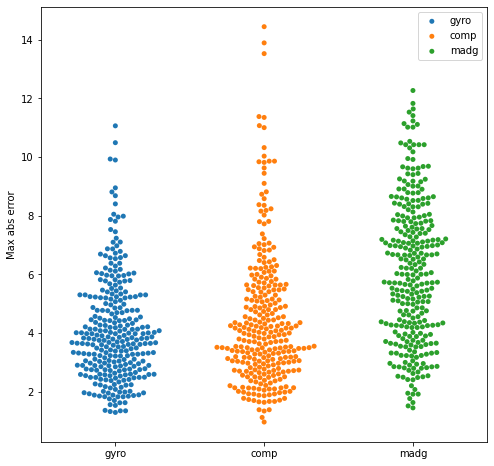

In [184]:
d={'gyro': max_err_gyro,'comp': max_err_comp,'madg':max_err_madg}
df2=pd.DataFrame(d)
from seaborn import swarmplot
fig = plt.figure(figsize=(8, 8))
# Now we can use Seaborn to create the swarm plot.
swarmplot(data=df2, ax=plt.gca())
# Tweak the plot a little
plt.legend(['gyro','comp','madg']) # Label for the y-axis
plt.ylabel('Max abs error')  # Label fo
plt.show()

In [185]:
with open(r"D:\ROMIU\ROMIU_final_results\result_AA.csv",'a',newline="") as f_in:
    # Write header unchanged
    writer = csv.writer(f_in)
    writer.writerow(max_err_gyro)
    writer.writerow(max_err_comp)
    writer.writerow(max_err_madg)
    writer.writerow(rom_gyro)
    writer.writerow(rom_comp)
    writer.writerow(rom_madg)
    writer.writerow(rom_mcp)


In [186]:

print(np.mean(max_err_gyro))
print(np.mean(max_err_comp))
print(np.mean(max_err_madg))


print(np.std(max_err_gyro))
print(np.std(max_err_comp))
print(np.std(max_err_madg))

4.105745602054272
4.459182488066774
6.116920158182077
1.7520490797696553
2.2877615940677263
2.407499605285507


In [187]:
rom_mocap=[]
for j in range(len(_mocap)):
    rom_mocap.append(np.max(_mocap[j]))
print(np.mean(abs(np.subtract(rom_gyro,rom_mocap))))
print(np.mean(abs(np.subtract(rom_comp,rom_mocap))))
print(np.mean(abs(np.subtract(rom_madg,rom_mocap))))
print(np.std(abs(np.subtract(rom_gyro,rom_mocap))))
print(np.std(abs(np.subtract(rom_comp,rom_mocap))))
print(np.std(abs(np.subtract(rom_madg,rom_mocap))))

2.5536396000514694
2.994730778684813
2.5269347372200923
1.8867215397681494
2.297723996594312
1.8795322361773552


In [188]:
rom=[]
i=0
mean=[]
for ang in rom_gyro:
    i=i+1  
    mean.append(ang)
    if i==3:
        rom.append(np.mean(mean))
        i=0
        mean=[]
print(np.mean(rom))
print(np.std(rom))
print(rom)

147.74800234234104
10.048906796258526
[159.62862317687578, 145.5426323314491, 150.5938386523455, 141.84031137101758, 140.00998006531162, 142.24302366818222, 152.69046924575, 150.87960390307137, 154.87519491599463, 150.25950235553773, 152.69774960240076, 147.93189351509608, 144.55374689951586, 147.64665599806787, 147.59501441723043, 159.4754428447776, 145.32672468998393, 154.85724866637835, 146.7121223764456, 134.734472835231, 141.18163057293552, 135.04600748711883, 131.55092307775988, 135.5625344472046, 134.14974769174808, 130.1397276141661, 141.93247632145753, 155.98874233534016, 149.47057841886615, 154.47219099059785, 154.93863496045688, 147.21020331721178, 147.8142716710254, 154.5108786221167, 144.78255958120897, 148.36294094418972, 153.1268908378967, 164.09128852379487, 162.34732753196252, 132.68699376002058, 127.1681544474427, 137.11781119940076, 156.35764212142357, 156.35764212142357, 152.34582364348782, 169.12610457351914, 149.89899409843323, 156.26300633809606, 138.647137481900

In [194]:
with open(r"D:\ROMIU\ROMIU_final_results\AA_ICC.csv",'w',newline='') as f_in:
    header = ['sub','clinician1','rom1','clinician2','rom2']
    writer = csv.writer(f_in)
    writer.writerow(header)
    a=0
    # Write the data 
    for i in range(int(len(rom)/3)):
        row1=[a,'A',rom[3*i],'A',rom[(3*i)+1]]
        row2=[a,'B',rom[(3*i)+1],'C',rom[(3*i)+2]]
        a=a+1
        writer.writerow(row1)
        writer.writerow(row2)

In [195]:
data = pd.read_csv(r"D:\ROMIU\ROMIU_final_results\AA_ICC.csv")
icc1 = pg.intraclass_corr(data=data, targets='sub', raters='clinician1', ratings='rom1')
icc2 = pg.intraclass_corr(data=data, targets='sub', raters='clinician2', ratings='rom2')

pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 200)
print(icc1)
print(icc2)

    Type              Description       ICC         F  df1  df2      pval         CI95%
0   ICC1   Single raters absolute  0.668976  5.041854   31   32  0.000008  [0.43, 0.82]
1   ICC2     Single random raters  0.668291  4.979744   31   31  0.000012  [0.42, 0.82]
2   ICC3      Single fixed raters  0.665538  4.979744   31   31  0.000012  [0.42, 0.82]
3  ICC1k  Average raters absolute  0.801660  5.041854   31   32  0.000008    [0.6, 0.9]
4  ICC2k    Average random raters  0.801168  4.979744   31   31  0.000012   [0.59, 0.9]
5  ICC3k     Average fixed raters  0.799186  4.979744   31   31  0.000012   [0.59, 0.9]
    Type              Description       ICC         F  df1  df2      pval         CI95%
0   ICC1   Single raters absolute  0.619736  4.259505   31   32  0.000050  [0.35, 0.79]
1   ICC2     Single random raters  0.620708  4.317682   31   31  0.000052  [0.36, 0.79]
2   ICC3      Single fixed raters  0.623896  4.317682   31   31  0.000052   [0.36, 0.8]
3  ICC1k  Average raters absolut

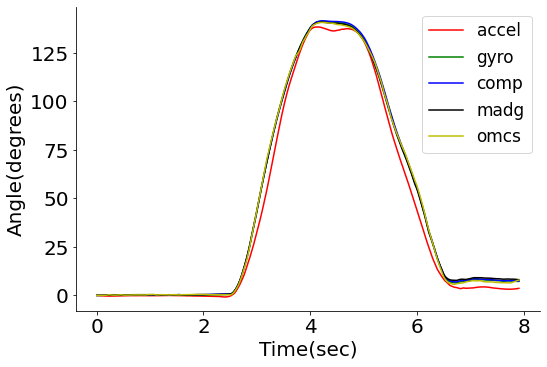

In [15]:
plt.rcParams["figure.figsize"] = [8.00, 5.50]
plt.rcParams["figure.autolayout"] = True
fg, ax = plt.subplots()
ax.plot(_2322[5].Time,_2322[0],'r')
ax.plot(_2322[5].Time,_2322[1],'g')
ax.plot(_2322[5].Time,_2322[2],'b')
ax.plot(_2322[5].Time,_2322[3],'k')
ax.plot(_2322[5].Time,_2322[4],'y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
plt.xlabel('Time(sec)')
plt.ylabel('Angle(degrees)')
plt.legend(['accel','gyro','comp','madg','omcs'],loc='upper right', fontsize=17)
plt.savefig(r'D:\sample_output.svg')
plt.show()

In [319]:
rom_gyro=[]
rom_comp=[]
rom_madg=[]
MOCAP_rom=[]
max_err_acc=[]
max_err_gyro=[]
max_err_comp=[]
variance=[]
_mean=[]
_mean_x=[]
_mean_y=[]
_mean_z=[]
_gyro=[]
_comp=[]
_madg=[]
_mocap=[]
d11=[]
d12=[]
d13=[]
d21=[]
d22=[]
d23=[]
max_err_madg=[]

def validatn(imu_file,mcp_file):
    imu_col =['gyrox1','gyroy1','gyroz1','accelx1','accely1','accelz1','Time']
    mcp_col=['Time','org_x','org_y','org_z','xvec_x','xvec_y','xvec_z','zvec_x','zvec_y','zvec_z']
    imu = pd.read_csv(imu_file, usecols=imu_col)
    mcp = pd.read_csv(mcp_file, usecols=mcp_col)
    t=imu.Time
    for i in range(9):
        mcp[mcp.columns[i+1]]=savgol_filter(mcp[mcp.columns[i+1]],51,3)
    for i in range(3):
        imu[imu.columns[i+3]]=savgol_filter(imu[imu.columns[i+3]],101,3)
    anew=pd.DataFrame()
    anew['Time']=t
    for col in mcp.columns:
        f=interpolate.interp1d(mcp.Time,mcp[col],fill_value="extrapolate")
        anew[col]=f(t)
    mcp=anew
    
    yvec1=[]
    xvec1=[]
    ort=[]
    # centroid_x=np.add(mcp.org_x,mcp.xvec_x)
    # centroid_x=np.add(centroid_x,mcp.zvec_x)/3
    # centroid_y=np.add(mcp.org_y,mcp.xvec_y)
    # centroid_y=np.add(centroid_y,mcp.zvec_y)/3
    # centroid_z=np.add(mcp.org_z,mcp.xvec_z)
    # centroid_z=np.add(centroid_z,mcp.zvec_z)/3
    # vec1_mags=[]
    # vec2_mags=[]
    # vec3_mags=[]
    # for j in range(len(mcp.org_x)):
    #     vec1_mag=np.linalg.norm(np.array([mcp.org_x[j]-mcp.xvec_x[j],mcp.org_y[j]-mcp.xvec_y[j],mcp.org_z[j]-mcp.xvec_z[j]]))
    #     vec2_mag=np.linalg.norm(np.array([mcp.org_x[j]-mcp.zvec_x[j],mcp.org_y[j]-mcp.zvec_y[j],mcp.org_z[j]-mcp.zvec_z[j]]))
    #     vec3_mag=np.linalg.norm(np.array([mcp.xvec_x[j]-mcp.zvec_x[j],mcp.xvec_y[j]-mcp.zvec_y[j],mcp.xvec_z[j]-mcp.zvec_z[j]]))
    #     vec1_mags.append(vec1_mag)
    #     vec2_mags.append(vec2_mag)
    #     vec3_mags.append(vec3_mag)
    # vec_mag_deviation=[np.sum(np.multiply(vec1_mags,vec1_mags)),np.sum(np.multiply(vec2_mags,vec2_mags)),np.sum(np.multiply(vec3_mags,vec3_mags))]
    # min_dev=np.argmin(vec_mag_deviation) 
    for j in range(len(mcp.org_x)):
        # org=np.array([mcp.org_x[j]-centroid_x[j],mcp.org_y[j]-centroid_y[j],mcp.org_z[j]-centroid_z[j]])
        # xvec=np.array([mcp.xvec_x[j]-centroid_x[j],mcp.xvec_y[j]-centroid_y[j],mcp.xvec_z[j]-centroid_z[j]])
        # zvec=np.array([mcp.zvec_x[j]-centroid_x[j],mcp.zvec_y[j]-centroid_y[j],mcp.zvec_z[j]-centroid_z[j]])
        # if min_dev==0:
        #     yvec1=org
        #     xvec1=xvec
        # elif min_dev==1:
        #     yvec1=org
        #     xvec1=zvec
        # elif min_dev==2:
        #     yvec1=zvec
        #     xvec1=xvec
        xvec1=np.array([mcp.org_x[j]-mcp.xvec_x[j],mcp.org_y[j]-mcp.xvec_y[j],mcp.org_z[j]-mcp.xvec_z[j]])
        yvec1=np.array([mcp.org_x[j]-mcp.zvec_x[j],mcp.org_y[j]-mcp.zvec_y[j],mcp.org_z[j]-mcp.zvec_z[j]])
        normx=np.linalg.norm(xvec1)
        yvec2=yvec1-((np.dot(xvec1/normx,yvec1)/np.dot(xvec1/normx,xvec1/normx))*(xvec1/normx))
        normy=np.linalg.norm(yvec2)
        zvec1=np.cross(xvec1/normx,yvec2/normy)
        normz=np.linalg.norm(zvec1)
        ort1=np.array([[xvec1[0]/normx,yvec2[0]/normy,zvec1[0]/normz],
                    [xvec1[1]/normx,yvec2[1]/normy,zvec1[1]/normz],
                    [xvec1[2]/normx,yvec2[2]/normy,zvec1[2]/normz]])
        ort.append(ort1)
        d21.append(normx)
        d22.append(normy)
        d23.append(normz)
    
    MOCAP_an=[]
    for j in range(len(ort)):
        s1=np.dot(ort[0].transpose(),ort[j])
        th=(np.trace(s1)-1.0)*0.5
        if th>1:
            th=1
        t=np.arccos(th)
        MOCAP_an.append(t)
    MOCAP=np.rad2deg(MOCAP_an)

############################# IMU ###################################################################  
    
    acc01=imu.accelx1
    acc02=imu.accely1
    acc03=imu.accelz1
    acc11=acc01-0.032051
    acc12=acc02+0.009519
    acc13=acc03+0.125074
    acc21=np.add((2.007463*acc11),(-0.000148*acc12))
    accx1=np.add(acc21,(0.002320*acc13))
    acc22=np.add((-0.000148*acc11),(1.993274*acc12))
    accy1=np.add(acc22,(-0.000060*acc13))
    acc23=np.add((0.002320*acc11),(-0.000060*acc12))
    accz1=np.add(acc23,( 1.986062*acc13))
  
    meen_x=np.mean(imu.gyrox1[:1000])
    meen_y=np.mean(imu.gyroy1[:1000])
    meen_z=np.mean(imu.gyroz1[:1000])
    _mean_x.append(meen_x)
    _mean_y.append(meen_y)
    _mean_z.append(meen_z)
    if -0.367188<meen_x<0.632812 and 0.78891<meen_y<1.78891 and -1.9483<meen_z<-0.9483:
        angx=np.deg2rad(imu.gyrox1-np.mean(imu.gyrox1[:1000]))
        angy=np.deg2rad(imu.gyroy1-np.mean(imu.gyroy1[:1000]))
        angz=np.deg2rad(imu.gyroz1-np.mean(imu.gyroz1[:1000]))
    else:
        angx=np.deg2rad(imu.gyrox1-0.32372708)
        angy=np.deg2rad(imu.gyroy1-1.273188007)
        angz=np.deg2rad(imu.gyroz1+1.421987881)

    var=np.std(imu.gyrox1[:1000])+np.std(imu.gyroy1[:1000])+np.std(imu.gyroz1[:1000])
    meen=abs(np.mean(imu.gyrox1[:1000]))+abs(np.mean(imu.gyroy1[:1000]))+abs(np.mean(imu.gyroz1[:1000]))
   
############################## Gyroscope ##################################################
    ang_gyro=[0]
    s_gyro=[1,0,0,0]
    for j in range(len(angx)-1):
            mag_gyro=np.linalg.norm([angx[j+1],angy[j+1],angz[j+1]]) 
            axis_of_rot=[angx[j+1]/mag_gyro,angy[j+1]/mag_gyro,angz[j+1]/mag_gyro]
            theta= 0.0017*mag_gyro
            q0=math.cos(theta/2)
            q1=(axis_of_rot[0])*math.sin(theta/2)
            q2=(axis_of_rot[1])*math.sin(theta/2)
            q3=(axis_of_rot[2])*math.sin(theta/2)
            q_gyro=[q0,q1,q2,q3]
            s_gyro=quaternion_multiply(s_gyro,q_gyro)
            ang_gyro.append(np.rad2deg(2*np.arccos(s_gyro[0])))
    IMU2=ang_gyro
    _gyro.append(IMU2)
###################### Complementary filter ###############################################
    
    if meen<=4.55:
        a=0.0001
    elif meen>4.55 and meen<=5.5:
        a=0.005
    else:
        a=0.007
    max_err_comp_sub=[]
    q4=[]
    Q1=[]
    ang_comp=[0]
    for j in range(len(angx)):
        Q=[0,accx1[j],accy1[j],accz1[j]]
        Q1.append(Q)
    for j in range(len(angx)-1):
        norm=np.linalg.norm([angx[j+1],angy[j+1],angz[j+1]]) 
        axis_of_rot=[angx[j+1]/norm,angy[j+1]/norm,angz[j+1]/norm]
        theta= 0.0017*norm
        q0=math.cos(theta/2)
        q1=(axis_of_rot[0])*math.sin(theta/2)
        q2=(axis_of_rot[1])*math.sin(theta/2)
        q3=(axis_of_rot[2])*math.sin(theta/2)
        q_comp=[q0,q1,q2,q3]
        q4.append(q_comp)
    s_comp=q4[0]
    for j in range(len(angx)-1):
        dummy=s_comp
        normq5=((dummy[0]*dummy[0])+(dummy[1]*dummy[1])+(dummy[2]*dummy[2])+(dummy[3]*dummy[3]))
        invq5=[s_comp[0]/normq5,-1*s_comp[1]/normq5,-1*s_comp[2]/normq5,-1*s_comp[3]/normq5]
        qupdat1=quaternion_multiply(s_comp,Q1[j+1])
        qupdate=quaternion_multiply(qupdat1,invq5)
        norm1=np.sqrt((qupdate[0]*qupdate[0])+(qupdate[1]*qupdate[1])+(qupdate[2]*qupdate[2])+(qupdate[3]*qupdate[3]))
        init=Q1[0][1:]
        new_qup=[qupdate[0]/norm1,qupdate[1]/norm1,qupdate[2]/norm1,qupdate[3]/norm1]
        rot_ax=np.cross(new_qup[1:],init)
        norm=np.linalg.norm(rot_ax)
        axis_of_rot=rot_ax/norm
        thet=(np.dot(new_qup[1:],init))/((np.linalg.norm(new_qup[1:])*np.linalg.norm(init)))
        theta=np.arccos(thet)
        q0=math.cos(a*theta/2)
        q1=(axis_of_rot[0])*math.sin(a*theta/2)
        q2=(axis_of_rot[1])*math.sin(a*theta/2)
        q3=(axis_of_rot[2])*math.sin(a*theta/2)
        qt=[q0,q1,q2,q3]
        s_comp=quaternion_multiply(qt,s_comp)
        finaltheta=np.rad2deg(2*np.arccos(s_comp[0]))
        if j<(len(q4)-1):
            s_comp=quaternion_multiply(s_comp,q4[j+1])
        ang_comp.append(finaltheta)
    IMU3=ang_comp
    _comp.append(IMU3)
    max_err_comp.append(np.max(abs(np.subtract(IMU3[:len(IMU3)-500],MOCAP[:len(IMU3)-500]))))
    
# #     ######################## Madgwick filter #############################################
    
    if  meen>4.55:
        beta=0.0001
    else:
        beta=0.000005
    
    s=[1,0,0,0]
    q=[1,0,0,0]
    ang_madg=[0]
    for j in range(len(angx)-1):
        q_madg=[0,angx[j+1],angy[j+1],angz[j+1]]
        # Normalise accelerometer measurement
        norm_acc=np.linalg.norm([accx1[j+1],accy1[j+1],accz1[j+1]])
        
        # Gradient descent algorithm corrective step
        f = np.array([
            2*((accx1[0]*(0.5-(q[2]*q[2])-(q[3]*q[3])))+(accy1[0]*((q[0]*q[3])+(q[1]*q[2])))+(accz1[0]*((q[1]*q[3])-(q[0]*q[2])))) - (accx1[j+1]/norm_acc),
            2*((accx1[0]*((q[1]*q[2])-(q[0]*q[3])))+(accy1[0]*((0.5-q[1]*q[1])-(q[3]*q[3])))+(accz1[0]*((q[0]*q[1])+(q[2]*q[3])))) - (accy1[j+1]/norm_acc),
            2*((accx1[0]*((q[0]*q[2])-(q[1]*q[3])))+(accy1[0]*((q[2]*q[3])-(q[0]*q[1])))+(accz1[0]*((0.5-q[1]*q[1])-(q[2]*q[2])))) - (accz1[j+1]/norm_acc)
        ])
        Jac = np.array([
            [(2*accy1[0]*q[3])-(2*accz1[0]*q[2]),(2*accy1[0]*q[2])+(2*accz1[0]*q[3]), ((-4*accx1[0]*q[2])+(2*accy1[0]*q[1])-(2*accz1[0]*q[0])),((-4*accx1[0]*q[3])+(2*accy1[0]*q[0])+(2*accz1[0]*q[1]))],
            [(-2*accx1[0]*q[3])+(2*accz1[0]*q[1]),((2*accx1[0]*q[2])-(4*accy1[0]*q[1])+(2*accz1[0]*q[0])),(2*accx1[0]*q[1])+(2*accz1[0]*q[3]), ((-2*accx1[0]*q[0])+(-4*accy1[0]*q[3])+(2*accz1[0]*q[2]))],
            [(2*accx1[0]*q[2])-(2*accy1[0]*q[1]), ((2*accx1[0]*q[3])-(2*accy1[0]*q[0])-(4*accz1[0]*q[1])), ( (2*accx1[0]*q[0])+(2*accy1[0]*q[3])+(-4*accz1[0]*q[2])),(2*accx1[0]*q[1])+(2*accy1[0]*q[2]) ]
        ])
        step =Jac.T.dot(f)
        norm_step=np.sqrt((step[0]*step[0])+(step[1]*step[1])+(step[2]*step[2])+(step[3]*step[3]))
        if norm_step!=0:
            step=[(step[0])/norm_step,(step[1])/norm_step,(step[2])/norm_step,(step[3])/norm_step]
        s1=[s[0]*0.5,s[1]*0.5,s[2]*0.5,s[3]*0.5]
        der_w=quaternion_multiply(s1,q_madg)
        der_w=[der_w[0]*0.0017,der_w[1]*0.0017,der_w[2]*0.0017,der_w[3]*0.0017]
        step=[step[0]*beta*0.0017,step[1]*beta*0.0017,step[2]*beta*0.0017,step[3]*beta*0.0017]
        s=np.add(s,der_w)
        q=np.subtract(s,step)
        s=q
        l=q
        if q[0]>1:
            l[0]=1
        theta=np.rad2deg(2*np.arccos(l[0]))
        ang_madg.append(theta)
    IMU4=ang_madg
    _madg.append(IMU4)
    max_err_madg.append(np.max(abs(np.subtract(IMU4[:len(IMU4)-500],MOCAP[:len(IMU4)-500]))))
    max_err_gyro.append(np.max(abs(np.subtract(IMU2[:len(IMU2)-500],MOCAP[:len(IMU2)-500]))))
    ang12=np.max(IMU2)
    ang13=np.max(IMU3)
    ang14=np.max(IMU4)
    _mocap.append(MOCAP)
    rom_gyro.append(ang12)
    rom_comp.append(ang13)
    rom_madg.append(ang14)
    ang2=np.max(MOCAP)
    MOCAP_rom.append(ang2)
    out=[IMU2,IMU3,IMU4,MOCAP,imu,mcp]
    return out